# An investigation into steering GPT-2 Small using of SAEs

## Setup

### If in Colab, install deps. Otherwise, setup autoreload.

In [1]:
try:
    import google.colab

    IN_COLAB = True
    %pip install sae-lens transformer-lens

except ImportError:
    # Local
    IN_COLAB = False

    import IPython

    ipython = IPython.get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

### Imports

In [2]:
import collections
import functools
import json
import math
import os
import requests
from pprint import pprint
import pathlib

import huggingface_hub
from matplotlib import pyplot as plt
import pandas as pd
from sae_lens import SAE
from tqdm import tqdm, trange
import torch as t
from transformer_lens import HookedTransformer

### Other settings

In [3]:
t.set_grad_enabled(False)

if t.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cuda" if t.cuda.is_available() else "cpu"

print(f"\nDevice: {DEVICE}")


Device: cuda


## Load Pretrained GPT-2 Small

In [5]:
gpt2_small = HookedTransformer.from_pretrained(
    "gpt2-small",
    device=DEVICE,
)

pprint(gpt2_small.cfg)

c:\Users\matth\Workspace\arena3\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': 'cuda',
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'normalization_type': 'LNPre',
 'num_experts': None,
 'original_architecture': 'GPT2LMHeadModel',
 'output_logits_soft_cap':

c:\Users\matth\Workspace\arena3\.venv\Lib\site-packages\torch\nn\modules\module.py:1160: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


## Import GPT-2 J-B SAEs

In [6]:
saes = [
    SAE.from_pretrained(
        release="gpt2-small-res-jb",
        sae_id=f"blocks.{layer}.hook_resid_pre",
        device=DEVICE,
    )[0]
    for layer in trange(gpt2_small.cfg.n_layers)
]

pprint(saes[0].cfg)

100%|██████████| 12/12 [00:11<00:00,  1.01it/s]

SAEConfig(architecture='standard',
          d_in=768,
          d_sae=24576,
          activation_fn_str='relu',
          apply_b_dec_to_input=True,
          finetuning_scaling_factor=False,
          context_size=128,
          model_name='gpt2-small',
          hook_name='blocks.0.hook_resid_pre',
          hook_layer=0,
          hook_head_index=None,
          prepend_bos=True,
          dataset_path='Skylion007/openwebtext',
          dataset_trust_remote_code=True,
          normalize_activations='none',
          dtype='torch.float32',
          device='cuda',
          sae_lens_training_version=None,
          activation_fn_kwargs={},
          neuronpedia_id='gpt2-small/0-res-jb')


## Query Neuronpedia, and save feature "explanations" for all SAEs to file for later search

This limits queries to Neuronpedia. The explanations are only ~70 MB

In [7]:
def load_explanations_from_saes(saes, save_path):
    try:
        with open(save_path, "r") as f:
            explanations = json.load(f)

    except FileNotFoundError:
        url = "https://www.neuronpedia.org/api/explanation/export"

        explanations = []

        for i, sae in enumerate(tqdm(saes)):
            model, sae_id = sae.cfg.neuronpedia_id.split("/")

            querystring = {"modelId": model, "saeId": sae_id}
            headers = {"X-Api-Key": os.getenv("NEURONPEDIA_TOKEN")}

            response = requests.get(url, headers=headers, params=querystring)
            explanations += response.json()

            with open(save_path, "w") as f:
                json.dump(explanations, f, indent=2)

    return explanations, save_path


explanations_fpath = "gpt2-small_res-jb_explanations.json"
explanations, _ = load_explanations_from_saes(saes, explanations_fpath)

100%|██████████| 12/12 [02:44<00:00, 13.70s/it]


## Find all features whose explanations contain keywords

In [8]:
def get_explanations_with_keywords_by_layer(explanations, keywords):
    explanations_filtered = collections.defaultdict(list)

    for explanation in explanations:
        if any(keyword in explanation["description"].upper() for keyword in keywords):
            layer = int(explanation["layer"].split("-")[0])
            explanations_filtered[layer].append(explanation)

    return explanations_filtered


keywords = ["AUSTRALIA"]

explanations_filtered = get_explanations_with_keywords_by_layer(explanations, keywords)

explanation_count = 0
explanation_counts_by_layer = {}
for layer in range(len(saes)):
    explanation_count_in_layer = len(explanations_filtered[layer])
    explanation_counts_by_layer[layer] = explanation_count_in_layer
    explanation_count += explanation_count_in_layer
    print(
        f"\nNumber of relevant features in layer {layer}: {explanation_count_in_layer}"
    )
    explanations_filtered_layer_str = "\n\t".join(
        [
            f"{explanation['index']}:\t{explanation['description']}"
            for explanation in explanations_filtered[layer]
        ]
    )
    print(f"\t{explanations_filtered_layer_str}")
print(
    f"Total relevant features: {explanation_count} ({explanation_count / len(explanations):.6f}% of total)"
)



Number of relevant features in layer 0: 3
	14487:	terms related to Australia or Australian entities
	15642:	references to geographical locations, with a focus on mentions of Australia
	20111:	mentions of the Australian Football League (AFL)

Number of relevant features in layer 1: 12
	4188:	text related to Australian culture
	18624:	mentions of ACT (Australian Capital Territory)
	8773:	words related to a specific Australian senator, Nick Xenophon
	10077:	Australian-related entities or contexts
	13068:	words related to the geographical location of New South Wales (NSW), Australia
	20027:	mentions of the political party "Labor" (likely referring to Australian Labor Party)
	12375:	terms related to the AFL (Australian Football League)
	13755:	names related to Australian political figures, specifically Malcolm Turnbull
	14665:	words related to sports, particularly focused on Australian football league (NRL) and players
	19207:	specific references to locations, especially related to New Sou

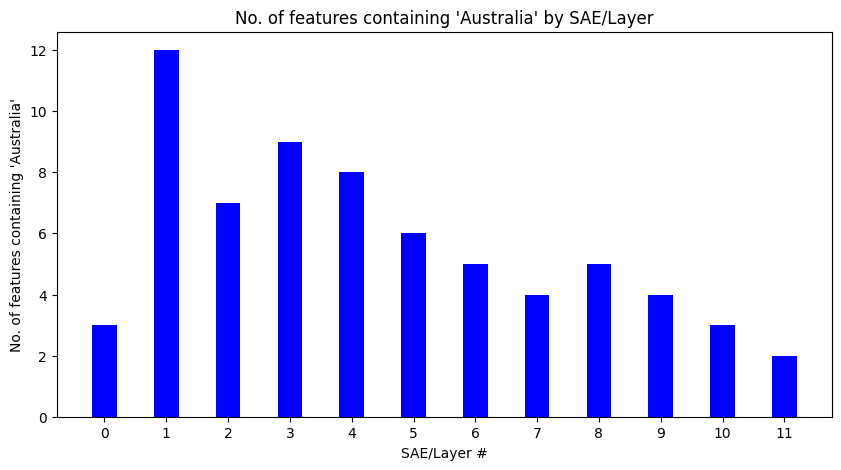

In [9]:
fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(
    explanation_counts_by_layer.keys(),
    explanation_counts_by_layer.values(),
    color="blue",
    width=0.4,
)

plt.xlabel("SAE/Layer #")
plt.xticks([l for l in explanation_counts_by_layer.keys()])
plt.ylabel(f"No. of features containing 'Australia'")
plt.title("No. of features containing 'Australia' by SAE/Layer")
plt.show()

## Find SAE feature indices that correlate with intended steering direction 

In [10]:
def run_model_and_get_filtered_activations(
    model, prompt, explanations_filtered, activation_threshold, quiet=True
):
    _, cache = model.run_with_cache(prompt, prepend_bos=True)

    if not quiet:
        tokens = model.to_tokens(prompt)
        print(f"Tokens: {tokens}")
        print(f"Token strings: {model.to_str_tokens(tokens)}")

    saes_out = {}
    acts_filtered = {}

    for layer, sae in enumerate(tqdm(saes)):
        if explanations_filtered[layer] == []:
            continue

        explanations_filtered_idx = t.tensor(
            [int(explanation["index"]) for explanation in explanations_filtered[layer]],
            device=DEVICE,
        )

        feature_acts = sae.encode(
            cache[sae.cfg.hook_name]
        )  # shape (batch, sequence, features)

        saes_out[layer] = sae.decode(feature_acts)

        feature_acts_vals_sorted, idx = feature_acts[
            :, :, explanations_filtered_idx
        ].sort(descending=True, dim=-1)

        feature_acts_idx_sorted = explanations_filtered_idx[idx]

        mask = feature_acts_vals_sorted >= activation_threshold

        acts_filtered[layer] = {
            "val": feature_acts_vals_sorted[mask].tolist(),
            "idx": feature_acts_idx_sorted[mask].tolist(),
            "desc": [],
        }

        for idx in acts_filtered[layer]["idx"]:
            acts_filtered[layer]["desc"].append(
                next(
                    expl["description"]
                    for expl in explanations_filtered[layer]
                    if int(expl["index"]) == idx
                )
            )

    return (
        cache,
        acts_filtered,
        saes_out,
    )


sv_prompt = "Sydney Opera House"
activation_threshold = 1.0

cache, acts_filtered, saes_out = run_model_and_get_filtered_activations(
    gpt2_small, sv_prompt, explanations_filtered, activation_threshold, quiet=True
)

# print_relevant_features(act_vals, act_idx, gpt2_small)

print("\nFiltered activations:")
pprint(acts_filtered)

100%|██████████| 12/12 [00:00<00:00, 88.48it/s]


Filtered activations:
{0: {'desc': [], 'idx': [], 'val': []},
 1: {'desc': ['words related to sports, particularly focused on Australian '
              'football league (NRL) and players'],
     'idx': [14665],
     'val': [5.82246732711792]},
 2: {'desc': ['locations or surnames related to Australian cities'],
     'idx': [20864],
     'val': [7.139648914337158]},
 3: {'desc': ['mentions of specific sports teams and related events, '
              'especially in the context of Australian football leagues'],
     'idx': [19448],
     'val': [2.3950774669647217]},
 4: {'desc': ['Australian Football League (AFL) team names'],
     'idx': [19972],
     'val': [4.3374762535095215]},
 5: {'desc': [], 'idx': [], 'val': []},
 6: {'desc': [], 'idx': [], 'val': []},
 7: {'desc': [], 'idx': [], 'val': []},
 8: {'desc': [], 'idx': [], 'val': []},
 9: {'desc': ['mentions of Australian Rules Football (AFL) teams and related '
              'terms'],
     'idx': [3036],
     'val': [3.887145757675

In [11]:
steering_vectors_positions_by_layer = {}
for layer, acts_filt_at_layer in acts_filtered.items():
    if len(acts_filt_at_layer["idx"]) == 0:
        continue

    position = saes_out[layer].shape[1] - 1
    idx = acts_filt_at_layer["idx"][0]
    val = acts_filt_at_layer["val"][0]
    steering_vector = saes[layer].W_dec[idx]
    explanation = next(
        expl["description"]
        for expl in explanations_filtered[layer]
        if int(expl["index"]) == idx
    )

    steering_vectors_positions_by_layer[layer] = {
        "idx": idx,
        "pos": position,
        "sv": steering_vector,
        "val": val,
        "expl": explanation,
    }
svps_by_layer_to_print = {
    layer: {
        "idx": svp["idx"],
        "val": svp["val"],
        "expl": svp["expl"],
    }
    for layer, svp in steering_vectors_positions_by_layer.items()
}
print(f"Total number of steering vectors: {len(steering_vectors_positions_by_layer)}\n")
print(f"Steering vector layers: {[k for k in steering_vectors_positions_by_layer]}\n")

for layer, svp in steering_vectors_positions_by_layer.items():
    print(
        f"Layer {layer}:\n\tIndex:\t\t{svp['idx']}\n\tValue:\t\t{svp['val']}\n\tExplanation:\t{svp['expl']}\n"
    )

Total number of steering vectors: 6

Steering vector layers: [1, 2, 3, 4, 9, 10]

Layer 1:
	Index:		14665
	Value:		5.82246732711792
	Explanation:	words related to sports, particularly focused on Australian football league (NRL) and players

Layer 2:
	Index:		20864
	Value:		7.139648914337158
	Explanation:	locations or surnames related to Australian cities

Layer 3:
	Index:		19448
	Value:		2.3950774669647217
	Explanation:	mentions of specific sports teams and related events, especially in the context of Australian football leagues

Layer 4:
	Index:		19972
	Value:		4.3374762535095215
	Explanation:	Australian Football League (AFL) team names

Layer 9:
	Index:		3036
	Value:		3.887145757675171
	Explanation:	mentions of Australian Rules Football (AFL) teams and related terms

Layer 10:
	Index:		10541
	Value:		6.6507368087768555
	Explanation:	mentions of the Australian Football League (AFL)



In [12]:
def steering_hook_all_layers(
    resid_pre, hook, steering_on, steering_vector, coeff, position
):
    # position = sae_out.shape[1]
    if steering_on:
        resid_pre[:, : position - 1, :] += coeff * steering_vector


def hooked_generate(
    prompt_batch, model, fwd_hooks=[], max_new_tokens=20, seed=None, **kwargs
):
    if seed is not None:
        t.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            **kwargs,
        )
    return result


def generate_multi_layer(
    prompt: str,
    model: HookedTransformer,
    steering_vectors_positions_by_layer: dict,
    coeff: float,
    sampling_kwargs,
    num_responses: int = 3,
    steering_on: bool = True,
    max_new_tokens: int = 20,
):
    model.reset_hooks()

    editing_hooks = []
    for layer, svp in steering_vectors_positions_by_layer.items():
        temp_hook_fn = functools.partial(
            steering_hook_all_layers,
            steering_on=steering_on,
            steering_vector=svp["sv"],
            coeff=coeff,
            position=svp["pos"],
        )
        editing_hooks.append((f"blocks.{layer}.hook_resid_post", temp_hook_fn))

    res = hooked_generate(
        [prompt] * num_responses,
        model,
        editing_hooks,
        max_new_tokens,
        seed=None,
        **sampling_kwargs,
    )

    return res


def print_res_str(res, model):
    res_str = model.to_string(res[:, 1:])
    for i in range(res.shape[0]):
        print(f"{res_str[i]}\n" + "-" * 80)


def print_res_str_tokens(res, model):
    for i in range(res.shape[0]):
        res_str = model.to_str_tokens(res[i, 1:])
        print(f"{res_str}\n" + "-" * 80)

In [13]:
prompt = "The White House is located in a country called"
coeff = 50

sampling_kwargs = {"temperature": 1.0, "top_p": 0.1, "freq_penalty": 1.0}

res = generate_multi_layer(
    prompt=prompt,
    model=gpt2_small,
    steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
    steering_on=False,
    coeff=coeff,
    sampling_kwargs=sampling_kwargs,
    num_responses=3,
)

print("UNSTEERED:")
print_res_str(res, gpt2_small)

res = generate_multi_layer(
    prompt=prompt,
    model=gpt2_small,
    steering_vectors_positions_by_layer={2: steering_vectors_positions_by_layer[2]},
    steering_on=True,
    coeff=coeff,
    sampling_kwargs=sampling_kwargs,
    num_responses=3,
)

print("STEERED:")
print_res_str(res, gpt2_small)

  0%|          | 0/20 [00:00<?, ?it/s]

UNSTEERED:
The White House is located in a country called the United States of America, and it's not just that. It's also that we're all
--------------------------------------------------------------------------------
The White House is located in a country called the United States of America, and it's not just the president who has been there.


--------------------------------------------------------------------------------
The White House is located in a country called the United States of America, and it's not just the president who has been in office. The
--------------------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

STEERED:
The White House is located in a country called Australia.

"It's the same as the government has to go and we have to be
--------------------------------------------------------------------------------
The White House is located in a country called Australia.

"It's the same as the state of has to go and it's at
--------------------------------------------------------------------------------
The White House is located in a country called Australia.

The Government has to be able to go on.

The government is also
--------------------------------------------------------------------------------


In [14]:
# fmt: off
landmark_country_pairs = [
    ["The Eiffel Tower"         , "France"], # The unsteered model answers 'Switzerland' approx. 50% of the time
    ["The Taj Mahal"            , "Tajikistan"], # Actually, India I think, but model baseline is this
    ["The Statue of Liberty"    , "The United States of America"],
    ["The Colosseum"            , "Italy"],
    ["The Great Pyramid of Giza", "Egypt"],
    ["Stonehenge"               , "The United Kingdom"], # Gives better results than England
    ["Petra"                    , "Jordan"],
    ["Macchu Picchu"            , "Peru"],
    ["Burj Khalifa"             , "Qatar"], # Actually The United Arab Emirates
    ["The Kremlin"              , "Russia"],
]
# fmt: on
for i, (landmark, country) in enumerate(landmark_country_pairs):
    prompt = f"{landmark} is located in a country called"
    res = generate_multi_layer(
        prompt=prompt,
        model=gpt2_small,
        steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
        steering_on=False,
        coeff=50,
        num_responses=10,
        sampling_kwargs=sampling_kwargs,
        max_new_tokens=10,
    )
    print_res_str(res, gpt2_small)

  0%|          | 0/10 [00:00<?, ?it/s]

The Eiffel Tower is located in a country called France, and it's the tallest building in the
--------------------------------------------------------------------------------
The Eiffel Tower is located in a country called France, and it's not just the tallest building
--------------------------------------------------------------------------------
The Eiffel Tower is located in a country called Switzerland. It was built in 1885 and has
--------------------------------------------------------------------------------
The Eiffel Tower is located in a country called Switzerland. It was built in 1859 by the
--------------------------------------------------------------------------------
The Eiffel Tower is located in a country called France, and it's the tallest building in the
--------------------------------------------------------------------------------
The Eiffel Tower is located in a country called France, and it's the tallest building in the
------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

The Taj Mahal is located in a country called Tajikistan, which is home to the largest
--------------------------------------------------------------------------------
The Taj Mahal is located in a country called Tajikistan, which is home to the largest
--------------------------------------------------------------------------------
The Taj Mahal is located in a country called Tajikistan, which is home to the largest
--------------------------------------------------------------------------------
The Taj Mahal is located in a country called Tajikistan, which is home to the largest
--------------------------------------------------------------------------------
The Taj Mahal is located in a country called Tajikistan, which is home to the largest
--------------------------------------------------------------------------------
The Taj Mahal is located in a country called Tajikistan, which is home to the largest
-------------------------------------------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

The Statue of Liberty is located in a country called the United States of America. It was built by
--------------------------------------------------------------------------------
The Statue of Liberty is located in a country called the United States of America. It was built by
--------------------------------------------------------------------------------
The Statue of Liberty is located in a country called the United States of America. It was built by
--------------------------------------------------------------------------------
The Statue of Liberty is located in a country called the United States of America. It was built by
--------------------------------------------------------------------------------
The Statue of Liberty is located in a country called the United States of America. It was built by
--------------------------------------------------------------------------------
The Statue of Liberty is located in a country called the United States of America. It was built by
-

  0%|          | 0/10 [00:00<?, ?it/s]

The Colosseum is located in a country called the "Siberian Peninsula" and is home
--------------------------------------------------------------------------------
The Colosseum is located in a country called the United States of America. It is one of
--------------------------------------------------------------------------------
The Colosseum is located in a country called Spain, and it is the only place in Europe
--------------------------------------------------------------------------------
The Colosseum is located in a country called the Netherlands, and it is home to some of
--------------------------------------------------------------------------------
The Colosseum is located in a country called the Netherlands, and it is one of the most
--------------------------------------------------------------------------------
The Colosseum is located in a country called the Mediterranean Sea, and it is home to some
-----------------------------------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

The Great Pyramid of Giza is located in a country called Egypt. It was built by the Egyptians in the
--------------------------------------------------------------------------------
The Great Pyramid of Giza is located in a country called Egypt. It was built by the Egyptians in the
--------------------------------------------------------------------------------
The Great Pyramid of Giza is located in a country called Egypt. It was built by the Egyptians in the
--------------------------------------------------------------------------------
The Great Pyramid of Giza is located in a country called Egypt. It was built by the Egyptians in the
--------------------------------------------------------------------------------
The Great Pyramid of Giza is located in a country called Egypt. It was built by the Egyptians in the
--------------------------------------------------------------------------------
The Great Pyramid of Giza is located in a country called Egypt. It was built by the Egypti

  0%|          | 0/10 [00:00<?, ?it/s]

Stonehenge is located in a country called Scotland, and it's home to the largest number
--------------------------------------------------------------------------------
Stonehenge is located in a country called the "Gulf of Mexico" and is home
--------------------------------------------------------------------------------
Stonehenge is located in a country called the North Sea, and it is one of the
--------------------------------------------------------------------------------
Stonehenge is located in a country called the North Sea, and it is one of the
--------------------------------------------------------------------------------
Stonehenge is located in a country called France, and it's the only place in Europe
--------------------------------------------------------------------------------
Stonehenge is located in a country called Norway, and it's the only place in the
--------------------------------------------------------------------------------
Stonehenge is located in a cou

  0%|          | 0/10 [00:00<?, ?it/s]

Petra is located in a country called Switzerland. It is the only place in the world
--------------------------------------------------------------------------------
Petra is located in a country called Poland, and she has been living there for the
--------------------------------------------------------------------------------
Petra is located in a country called Poland, and she has been living there for over
--------------------------------------------------------------------------------
Petra is located in a country called the United States of America. It is home to
--------------------------------------------------------------------------------
Petra is located in a country called the Netherlands, and she has been living in the
--------------------------------------------------------------------------------
Petra is located in a country called Switzerland. It is the only country in the world
--------------------------------------------------------------------------------
Petra is lo

  0%|          | 0/10 [00:00<?, ?it/s]

Macchu Picchu is located in a country called the Philippines, which is home to some of the
--------------------------------------------------------------------------------
Macchu Picchu is located in a country called the Caspian Sea, which is about 2
--------------------------------------------------------------------------------
Macchu Picchu is located in a country called China, and it's the only place in the
--------------------------------------------------------------------------------
Macchu Picchu is located in a country called the Caspian Sea, which is home to
--------------------------------------------------------------------------------
Macchu Picchu is located in a country called the Caspian Sea, which is home to
--------------------------------------------------------------------------------
Macchu Picchu is located in a country called the "Cambodia" and is home
--------------------------------------------------------------------------------
Macchu Picchu is located in a c

  0%|          | 0/10 [00:00<?, ?it/s]

Burj Khalifa is located in a country called Qatar, which has been the focus of international attention
--------------------------------------------------------------------------------
Burj Khalifa is located in a country called Qatar, which has been the focus of intense international
--------------------------------------------------------------------------------
Burj Khalifa is located in a country called Qatar, which has been under the control of the
--------------------------------------------------------------------------------
Burj Khalifa is located in a country called Qatar, which has been the target of an international
--------------------------------------------------------------------------------
Burj Khalifa is located in a country called Qatar, which has been under the control of the
--------------------------------------------------------------------------------
Burj Khalifa is located in a country called Qatar, which has been under the control of the
---------------------

  0%|          | 0/10 [00:00<?, ?it/s]

The Kremlin is located in a country called Russia, which has been under Russian control since the
--------------------------------------------------------------------------------
The Kremlin is located in a country called Russia, which has been the target of Russian aggression
--------------------------------------------------------------------------------
The Kremlin is located in a country called Russia, which has been accused of being behind the
--------------------------------------------------------------------------------
The Kremlin is located in a country called Russia, which has been under Russian control since the
--------------------------------------------------------------------------------
The Kremlin is located in a country called Russia, which has been accused of supporting the Syrian
--------------------------------------------------------------------------------
The Kremlin is located in a country called Russia, which has been the target of a series
------------------

In [15]:
def test_steering_of_landmark_location_in_model(
    landmark_country_pairs,
    model,
    steering_on,
    steering_vectors_positions_by_layer,
    steered_answer,
    coeff,
    quiet=False,
    strict=True,
    max_new_tokens=10,
):
    # country_max_length = max(len(country) for _, country in landmark_country_pairs)

    correct_counts = t.zeros(len(landmark_country_pairs), dtype=t.int)
    steering_counts = t.zeros(len(landmark_country_pairs), dtype=t.int)

    for i, (landmark, country) in enumerate(tqdm(landmark_country_pairs)):
        # if country != "Russia":
        #     continue
        prompt = f"{landmark} is located in a country called"
        res = generate_multi_layer(
            prompt=prompt,
            model=model,
            steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
            steering_on=steering_on,
            coeff=coeff,
            num_responses=100,
            sampling_kwargs=sampling_kwargs,
            max_new_tokens=max_new_tokens,
        )
        res_strs = gpt2_small.to_string(res[:, 1:])

        for res_str in res_strs:
            check_str = res_str[len(prompt) + 1 :].upper()
            if strict:
                if check_str.upper().startswith(country.upper()):
                    correct_counts[i] += 1
                if check_str.upper().startswith(steered_answer.upper()):
                    steering_counts[i] += 1
            else:
                if country.upper() in check_str:
                    correct_counts[i] += 1
                if steered_answer.upper() in check_str:
                    steering_counts[i] += 1

        if not quiet:
            print(
                f"{'STEERED' if steering_on else 'UNSTEERED'} test for landmark '{landmark}'"
            )
            print(f"Correct Answer: '{country}'\tSteered Answer: 'Australia'")
            print(f"\tNumber of correct responses: {correct_counts[i]}")
            print(f"\tNumber of steered responses: {steering_counts[i]}")

    return correct_counts, steering_counts


## Unsteered results:

In [16]:
correct_counts, steering_counts = test_steering_of_landmark_location_in_model(
    model=gpt2_small,
    landmark_country_pairs=landmark_country_pairs,
    steering_on=False,
    steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
    steered_answer="Australia",
    coeff=coeff,
    quiet=True,
    strict=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:10,  1.17s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:02<00:09,  1.23s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:03<00:07,  1.13s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:04<00:05,  1.07it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:04<00:04,  1.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:05<00:02,  1.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:05<00:02,  1.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:06<00:01,  1.49it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:07<00:00,  1.55it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


In [17]:
def print_steering_results(landmark_country_pairs, correct_counts, steering_counts):
    df = pd.DataFrame(
        {
            "Landmarks": [
                landmark_country_pairs[i][0] for i in range(len(landmark_country_pairs))
            ],
            "Expected Answers": [
                landmark_country_pairs[i][1] for i in range(len(landmark_country_pairs))
            ],
            "Percent Correct": correct_counts,
            "Percent Steered": steering_counts,
        }
    )
    df.style.format_index(str.upper, axis=1)
    pd.set_option("display.width", 200)

    print(df.to_string(index=False))


print_steering_results(landmark_country_pairs, correct_counts, steering_counts)

                Landmarks             Expected Answers  Percent Correct  Percent Steered
         The Eiffel Tower                       France               49                0
            The Taj Mahal                   Tajikistan              100                0
    The Statue of Liberty The United States of America              100                0
            The Colosseum                        Italy                0                0
The Great Pyramid of Giza                        Egypt              100                0
               Stonehenge           The United Kingdom               11                0
                    Petra                       Jordan                0                0
            Macchu Picchu                         Peru                0                0
             Burj Khalifa                        Qatar              100                0
              The Kremlin                       Russia              100                0


## Steered

In [18]:
correct_counts, steering_counts = test_steering_of_landmark_location_in_model(
    model=gpt2_small,
    landmark_country_pairs=landmark_country_pairs,
    steering_on=True,
    steering_vectors_positions_by_layer={2: steering_vectors_positions_by_layer[2]},
    steered_answer="Australia",
    coeff=50,
    quiet=True,
)

print_steering_results(landmark_country_pairs, correct_counts, steering_counts)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:06,  1.38it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:01<00:05,  1.56it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:01<00:04,  1.58it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:02<00:04,  1.48it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:03<00:03,  1.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:04<00:01,  1.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:05<00:01,  1.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:05<00:00,  1.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

                Landmarks             Expected Answers  Percent Correct  Percent Steered
         The Eiffel Tower                       France                0               47
            The Taj Mahal                   Tajikistan                0                0
    The Statue of Liberty The United States of America                0                0
            The Colosseum                        Italy                0               44
The Great Pyramid of Giza                        Egypt              100                0
               Stonehenge           The United Kingdom                0               46
                    Petra                       Jordan                0                0
            Macchu Picchu                         Peru                0                0
             Burj Khalifa                        Qatar                0                0
              The Kremlin                       Russia                0                0


## Not strict

### 10 tokens

In [19]:
correct_counts, steering_counts = test_steering_of_landmark_location_in_model(
    model=gpt2_small,
    landmark_country_pairs=landmark_country_pairs,
    steering_on=True,
    steering_vectors_positions_by_layer={2: steering_vectors_positions_by_layer[2]},
    steered_answer="Australia",
    coeff=50,
    quiet=True,
    strict=False,
    max_new_tokens=10,
)

print_steering_results(landmark_country_pairs, correct_counts, steering_counts)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:05,  1.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:01<00:04,  1.65it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:01<00:04,  1.71it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:02<00:03,  1.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:04<00:02,  1.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:04<00:02,  1.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:05<00:01,  1.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:06<00:00,  1.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                Landmarks             Expected Answers  Percent Correct  Percent Steered
         The Eiffel Tower                       France                0              100
            The Taj Mahal                   Tajikistan                0               38
    The Statue of Liberty The United States of America                0                6
            The Colosseum                        Italy                0               48
The Great Pyramid of Giza                        Egypt              100                6
               Stonehenge           The United Kingdom                0               55
                    Petra                       Jordan                0               14
            Macchu Picchu                         Peru                0                5
             Burj Khalifa                        Qatar                0               57
              The Kremlin                       Russia                0               49


### 50 tokens

In [20]:
correct_counts, steering_counts = test_steering_of_landmark_location_in_model(
    model=gpt2_small,
    landmark_country_pairs=landmark_country_pairs,
    steering_on=True,
    steering_vectors_positions_by_layer={2: steering_vectors_positions_by_layer[2]},
    steered_answer="Australia",
    coeff=50,
    quiet=True,
    strict=False,
    max_new_tokens=50,
)

print_steering_results(landmark_country_pairs, correct_counts, steering_counts)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:24,  2.70s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:05<00:21,  2.69s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:08<00:18,  2.68s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:10<00:15,  2.66s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:14<00:14,  2.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:17<00:12,  3.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:20<00:09,  3.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

                Landmarks             Expected Answers  Percent Correct  Percent Steered
         The Eiffel Tower                       France                0              100
            The Taj Mahal                   Tajikistan                0               44
    The Statue of Liberty The United States of America                0               14
            The Colosseum                        Italy                0               49
The Great Pyramid of Giza                        Egypt              100                6
               Stonehenge           The United Kingdom                0               54
                    Petra                       Jordan                0               13
            Macchu Picchu                         Peru                0               10
             Burj Khalifa                        Qatar                0               63
              The Kremlin                       Russia                0               46


## Try a range of coeffs and steer using one feature at a time and compare

In [21]:
coeffs = [
    0.0,
    0.1,
    0.2,
    0.5,
    1.0,
    2.0,
    5.0,
    10.0,
    20.0,
    50.0,
    100.0,
    500.0,
    1000.0,
    5000.0,
]

correct_counts_all_strict = t.zeros(
    (
        len(steering_vectors_positions_by_layer),
        len(coeffs),
        len(landmark_country_pairs),
    ),
    dtype=t.int,
)
steering_counts_all_strict = correct_counts_all_strict.clone().detach()

i = 0
for layer, svp in tqdm(steering_vectors_positions_by_layer.items()):
    for c, coeff in enumerate(coeffs):
        steering_on = False if math.isclose(coeff, 0.0) else True

        correct_counts_all_strict[i][c], steering_counts_all_strict[i][c] = (
            test_steering_of_landmark_location_in_model(
                model=gpt2_small,
                landmark_country_pairs=landmark_country_pairs,
                steering_on=steering_on,
                steering_vectors_positions_by_layer={layer: svp},
                steered_answer="Australia",
                coeff=coeff,
                quiet=True,
            )
        )
    i += 1


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:32<07:44, 92.98s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [03:00<05:59, 89.88s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 3/6 [04:27<04:26, 88.67s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [05:56<02:57, 88.69s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [07:25<01:28, 88.63s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 6/6 [08:51<00:00, 88.54s/it]


In [22]:
print(f"Coeffs: {coeffs}")
for i, key in enumerate(steering_vectors_positions_by_layer.keys()):
    print(f"\nLayer {key}")
    print(f"Feature Index:\t\t{steering_vectors_positions_by_layer[key]['idx']}")
    print(f"Feature Act Val:\t{steering_vectors_positions_by_layer[key]['val']}")
    print(f"Feature Explanation:\t{steering_vectors_positions_by_layer[key]['expl']}")
    print("Correct counts:")
    pprint(correct_counts_all_strict[i])
    print("Steering counts:")
    pprint(steering_counts_all_strict[i])

Coeffs: [0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0, 5000.0]

Layer 1
Feature Index:		14665
Feature Act Val:	5.82246732711792
Feature Explanation:	words related to sports, particularly focused on Australian football league (NRL) and players
Correct counts:
tensor([[ 47, 100, 100,   0, 100,   9,   0,   0, 100, 100],
        [ 48, 100, 100,   0, 100,  10,   0,   0, 100, 100],
        [ 51, 100, 100,   0, 100,   6,   0,   0, 100, 100],
        [ 41, 100, 100,   0, 100,   6,   0,   0, 100, 100],
        [ 50, 100, 100,   0, 100,   9,   0,   0, 100, 100],
        [ 46, 100,   0,   0, 100,  13,   0,   0, 100, 100],
        [  0,   0,   0,   0, 100,  11,   0,   0,   0, 100],
        [  0,   0,   0,   0, 100,   0,   0,   0,   0, 100],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 100],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0

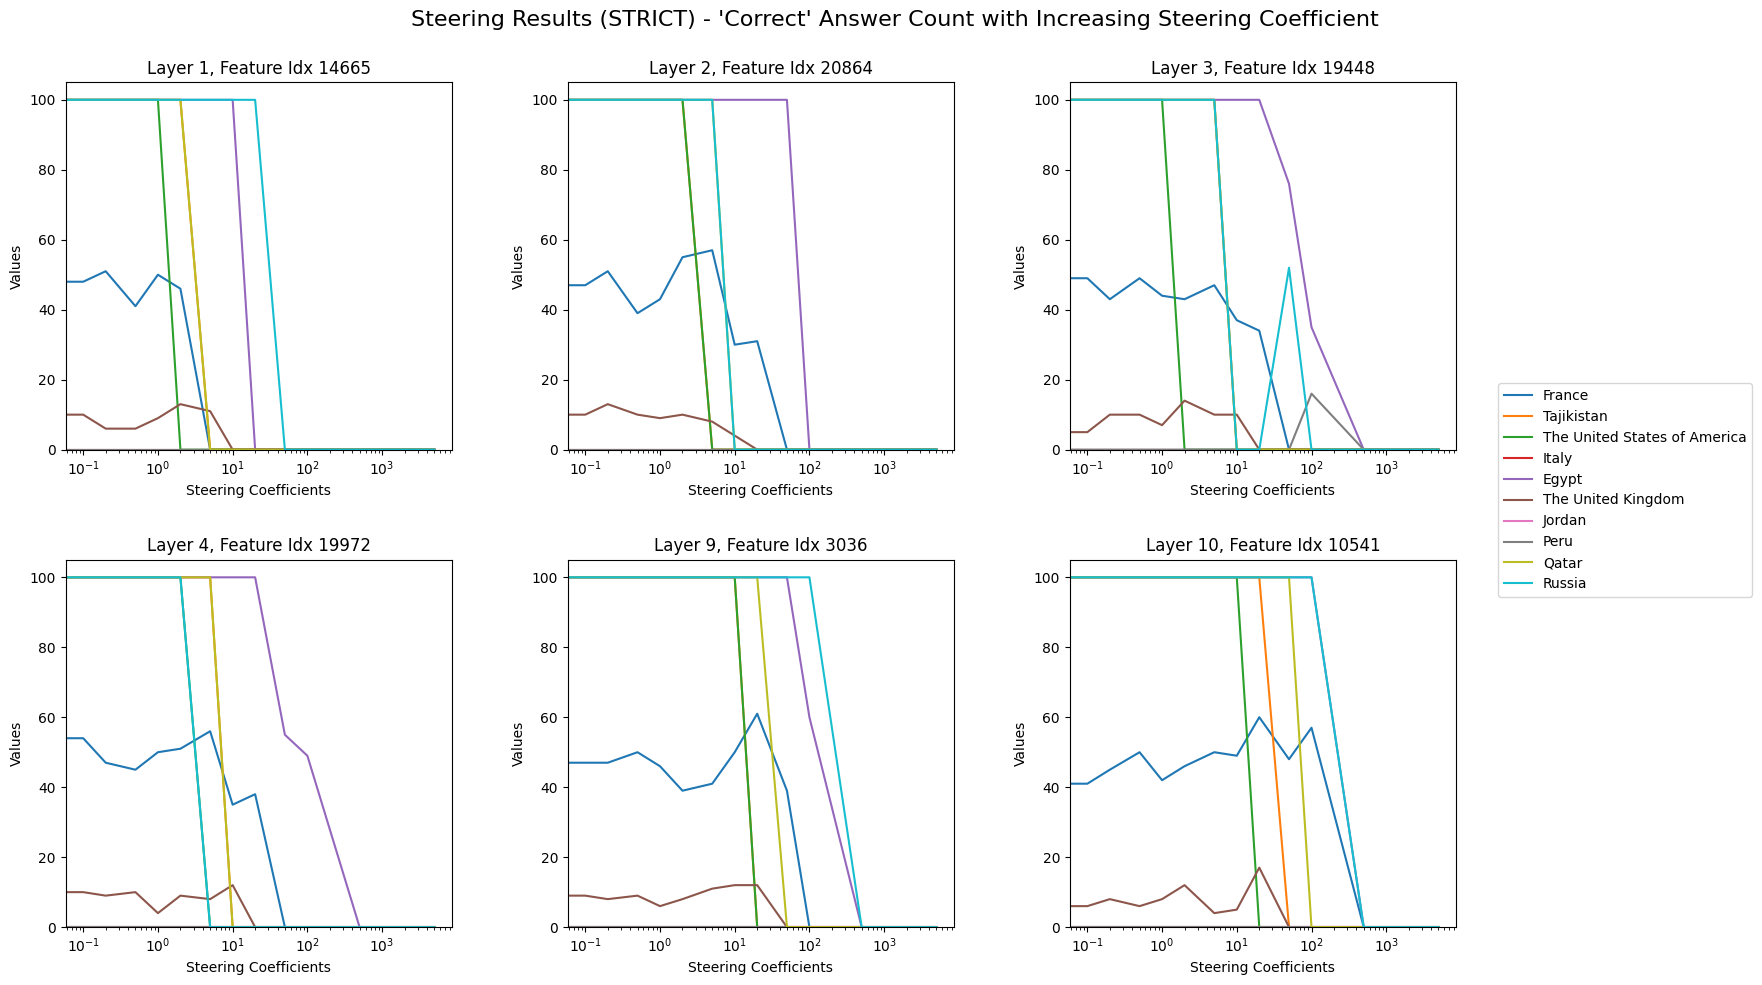

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def create_steering_plot(counts, steering_coeffs, suptitle, subplot_titles):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(suptitle, fontsize=16)
    axs_flat = axs.flatten()

    num_pairs = counts.shape[2]
    for i, ax in enumerate(axs_flat):
        counts_layer = counts[i]

        for j in range(num_pairs):
            ax.plot(
                steering_coeffs, counts_layer[:, j], label=landmark_country_pairs[j][1]
            )
            ax.set_xscale("log")
            ax.set_xlabel("Steering Coefficients")
            ax.set_ylabel("Values")
            ax.set_ylim([0, 105])
            ax.set_title(subplot_titles[i])

    handles, labels = axs_flat[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.98, 0.5), ncol=1)
    # fig.legend(axs_flat, labels=, loc="right", bbox_to_anchor=(0.91, 0.5))

    plt.tight_layout(rect=[0, 0, 0.82, 0.98])
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


create_steering_plot(
    counts=correct_counts_all_strict,
    steering_coeffs=coeffs,
    suptitle="Steering Results (STRICT) - 'Correct' Answer Count with Increasing Steering Coefficient",
    subplot_titles=[
        f"Layer {k}, Feature Idx {svp['idx']}"
        for k, svp in steering_vectors_positions_by_layer.items()
    ],
)

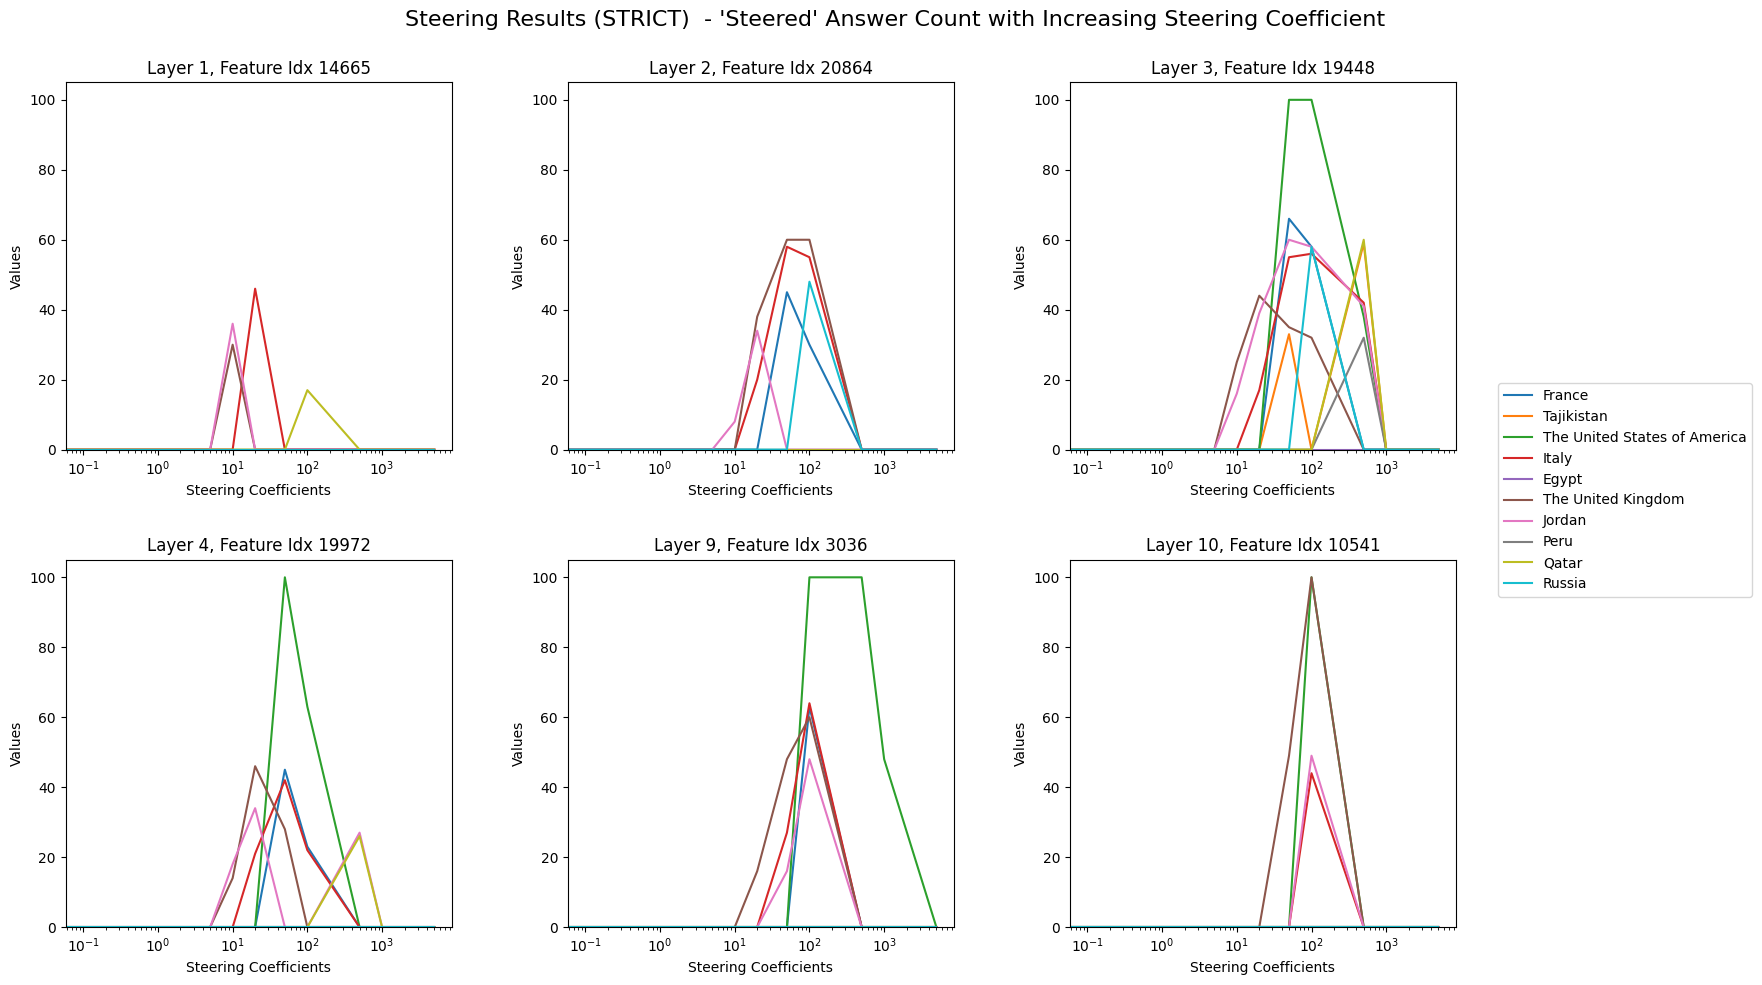

In [24]:
create_steering_plot(
    counts=steering_counts_all_strict,
    steering_coeffs=coeffs,
    suptitle="Steering Results (STRICT)  - 'Steered' Answer Count with Increasing Steering Coefficient",
    subplot_titles=[
        f"Layer {k}, Feature Idx {svp['idx']}"
        for k, svp in steering_vectors_positions_by_layer.items()
    ],
)

## Unstrict_10

In [25]:
correct_counts_all_unstrict = t.zeros(
    (
        len(steering_vectors_positions_by_layer),
        len(coeffs),
        len(landmark_country_pairs),
    ),
    dtype=t.int,
)
steering_counts_all_unstrict = correct_counts_all_unstrict.clone().detach()

i = 0
for layer, svp in tqdm(steering_vectors_positions_by_layer.items()):
    for c, coeff in enumerate(coeffs):
        steering_on = False if math.isclose(coeff, 0.0) else True

        correct_counts_all_unstrict[i][c], steering_counts_all_unstrict[i][c] = (
            test_steering_of_landmark_location_in_model(
                model=gpt2_small,
                landmark_country_pairs=landmark_country_pairs,
                steering_on=steering_on,
                steering_vectors_positions_by_layer={layer: svp},
                steered_answer="Australia",
                coeff=coeff,
                quiet=True,
                strict=False,
                max_new_tokens=10,
            )
        )
    i += 1

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:26<07:12, 86.58s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [02:59<06:00, 90.13s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 3/6 [04:32<04:34, 91.60s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [06:04<03:03, 91.80s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [07:36<01:31, 91.89s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 6/6 [09:10<00:00, 91.77s/it]


In [26]:
print(f"Coeffs: {coeffs}")
for i, key in enumerate(steering_vectors_positions_by_layer.keys()):
    print(f"\nLayer {key}")
    print(f"Feature Index:\t\t{steering_vectors_positions_by_layer[key]['idx']}")
    print(f"Feature Act Val:\t{steering_vectors_positions_by_layer[key]['val']}")
    print(f"Feature Explanation:\t{steering_vectors_positions_by_layer[key]['expl']}")
    print("Correct counts:")
    pprint(correct_counts_all_unstrict[i])
    print("Steering counts:")
    pprint(steering_counts_all_unstrict[i])

Coeffs: [0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0, 5000.0]

Layer 1
Feature Index:		14665
Feature Act Val:	5.82246732711792
Feature Explanation:	words related to sports, particularly focused on Australian football league (NRL) and players
Correct counts:
tensor([[ 52, 100, 100,   0, 100,  12,   0,   0, 100, 100],
        [ 44, 100, 100,   0, 100,   8,   0,   0, 100, 100],
        [ 49, 100, 100,   0, 100,   3,   0,   0, 100, 100],
        [ 46, 100, 100,   0, 100,  10,   0,   0, 100, 100],
        [ 50, 100, 100,   0, 100,   9,   0,   0, 100, 100],
        [ 50, 100,   0,   0, 100,  15,   0,   0, 100, 100],
        [  0,   0,   0,   0, 100,   7,   0,   0,   0, 100],
        [  0,   0,   0,   0, 100,   0,   0,   0,   0, 100],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 100],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0

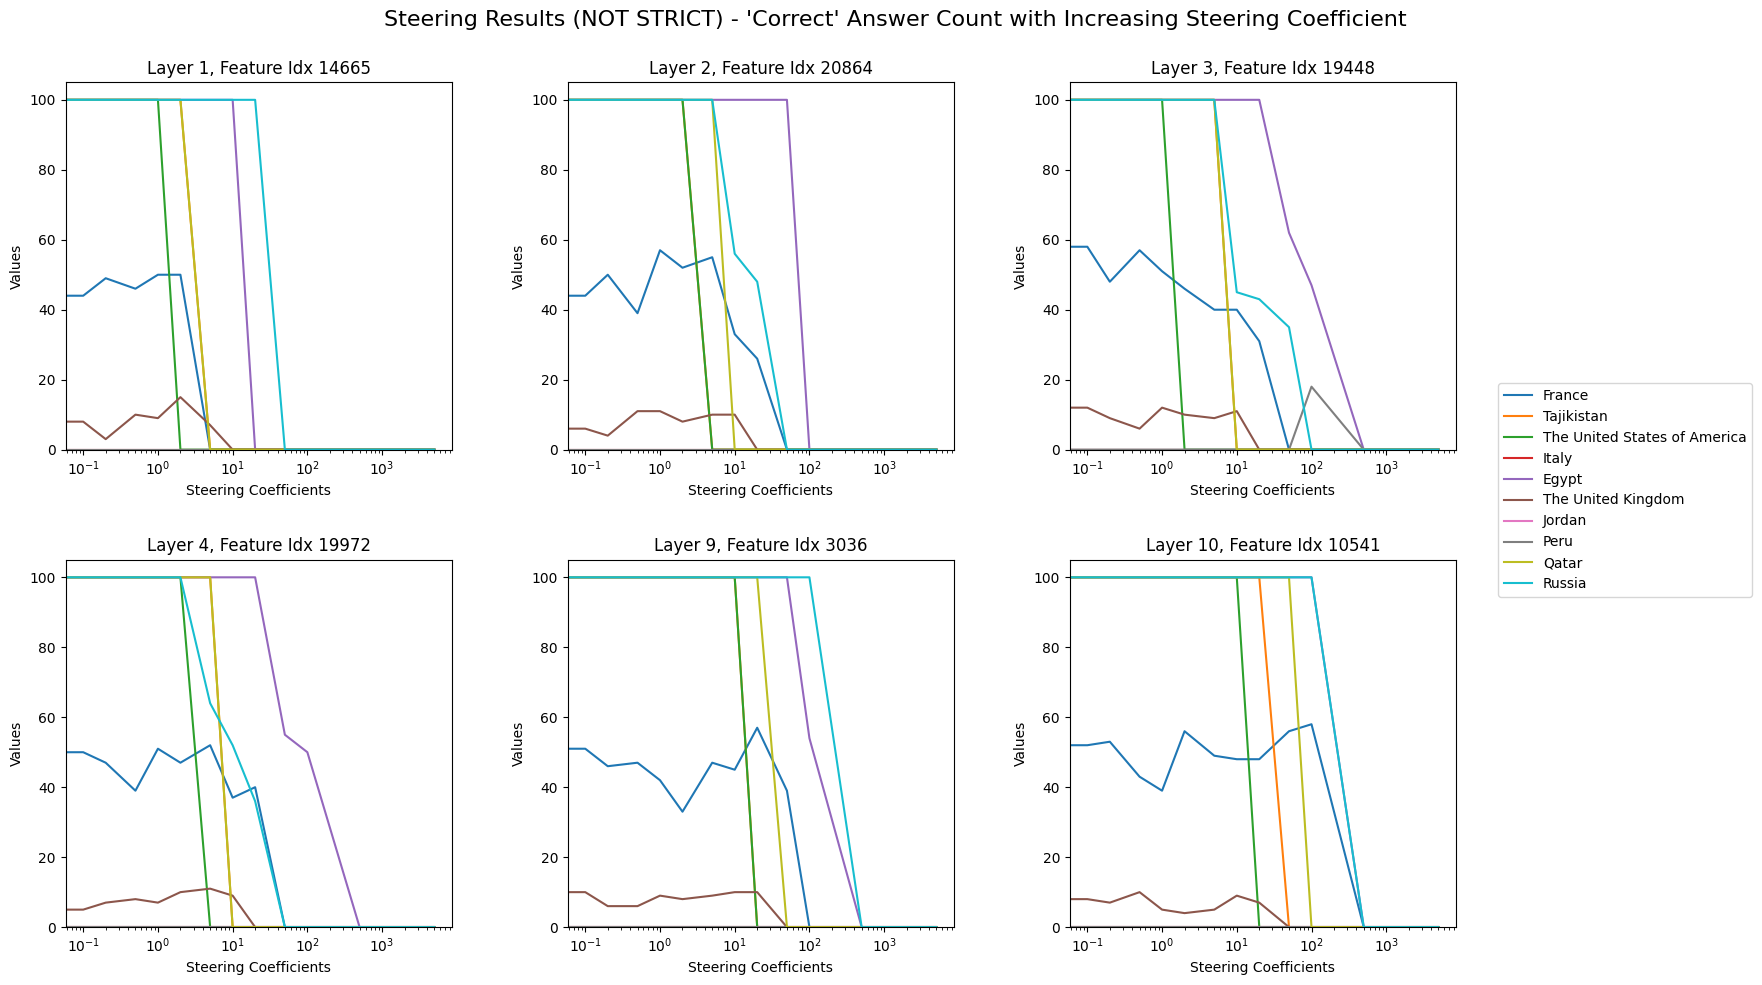

In [27]:
create_steering_plot(
    counts=correct_counts_all_unstrict,
    steering_coeffs=coeffs,
    suptitle="Steering Results (NOT STRICT) - 'Correct' Answer Count with Increasing Steering Coefficient",
    subplot_titles=[
        f"Layer {k}, Feature Idx {svp['idx']}"
        for k, svp in steering_vectors_positions_by_layer.items()
    ],
)

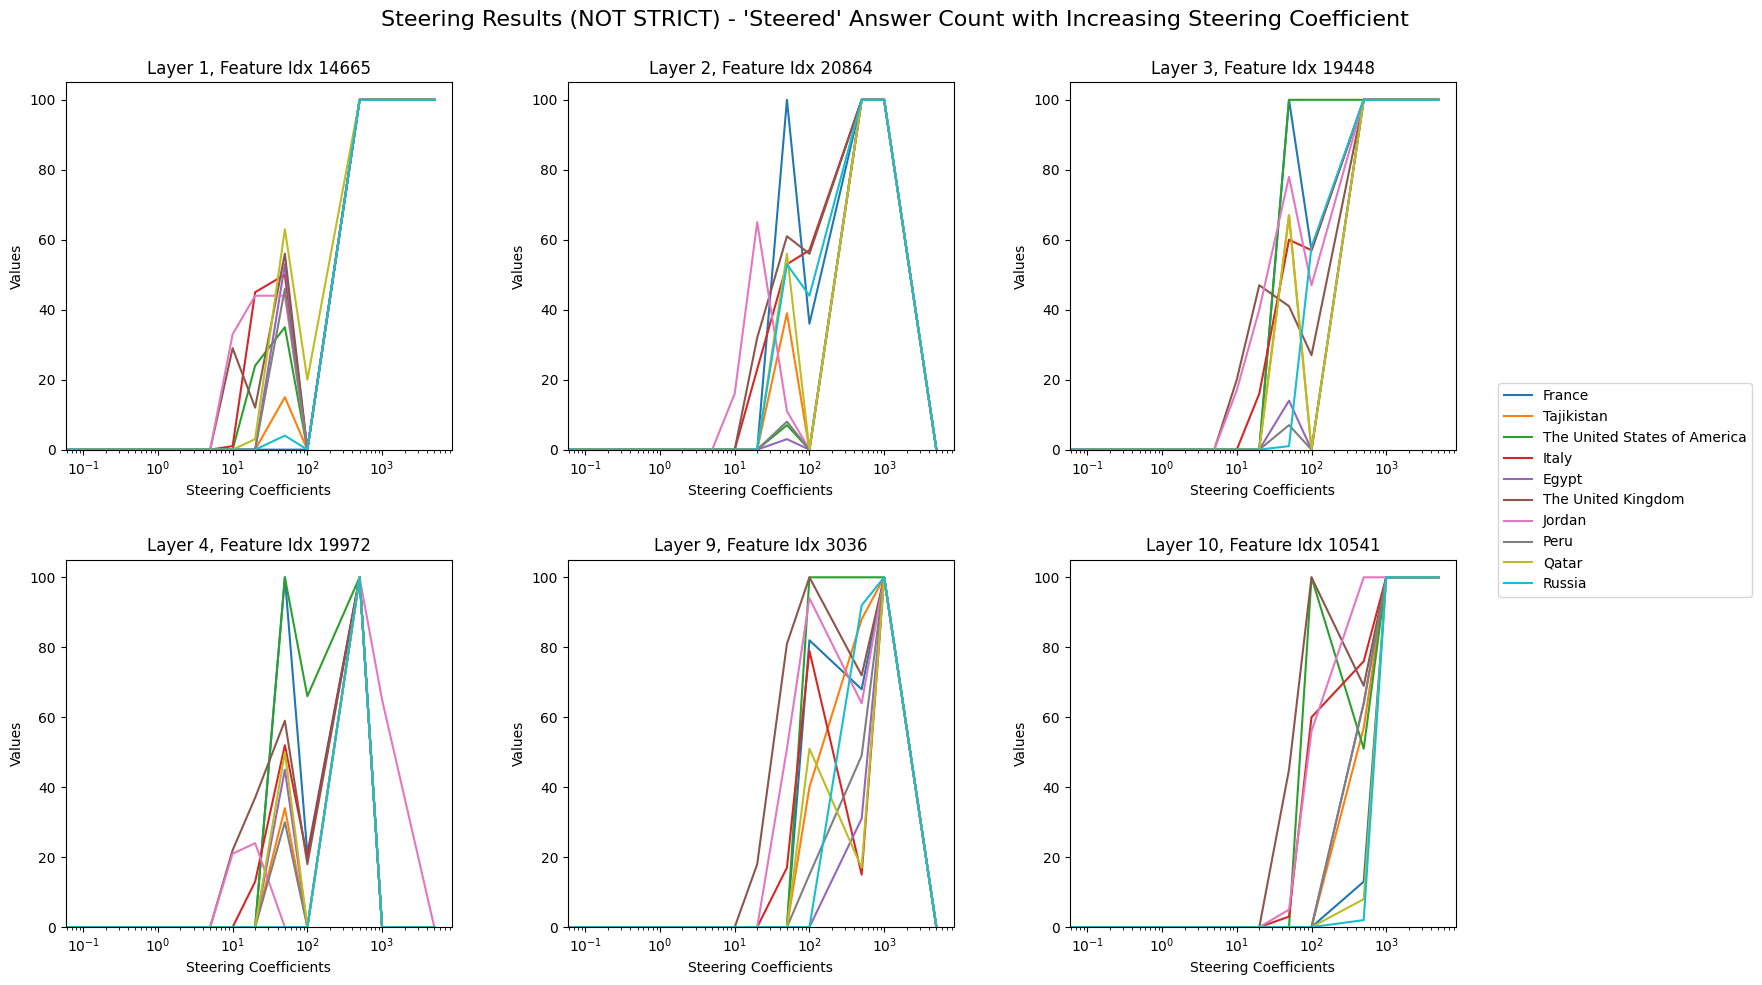

In [28]:
create_steering_plot(
    counts=steering_counts_all_unstrict,
    steering_coeffs=coeffs,
    suptitle="Steering Results (NOT STRICT) - 'Steered' Answer Count with Increasing Steering Coefficient",
    subplot_titles=[
        f"Layer {k}, Feature Idx {svp['idx']}"
        for k, svp in steering_vectors_positions_by_layer.items()
    ],
)

In [29]:
# Strict steering results by landmark.
for k in range(steering_counts_all_strict.shape[2]):
    print(landmark_country_pairs[k])
    print(coeffs)
    print(steering_counts_all_strict[:, :, k])  # shape (steering vectors, coeffs)

['The Eiffel Tower', 'France']
[0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0, 5000.0]
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 45, 30,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 66, 58,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 45, 23,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 63,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
       dtype=torch.int32)
['The Taj Mahal', 'Tajikistan']
[0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0, 5000.0]
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  0, 59,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,

tensor([[  0,   0,   0,   0,   0,   0,   0,  66,  46,   0,  17,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   8,  92, 163, 193,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  41, 100, 349, 362, 272,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  32, 101, 215, 108,  53,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  16,  91, 335, 100,  48,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  49, 293,   0,   0,   0]])
tensor([ 129,  456, 1124,  509,  590,  342])


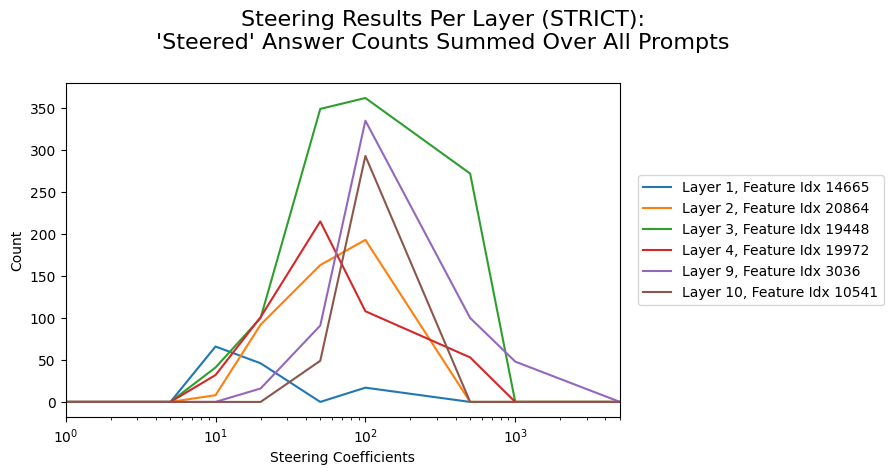

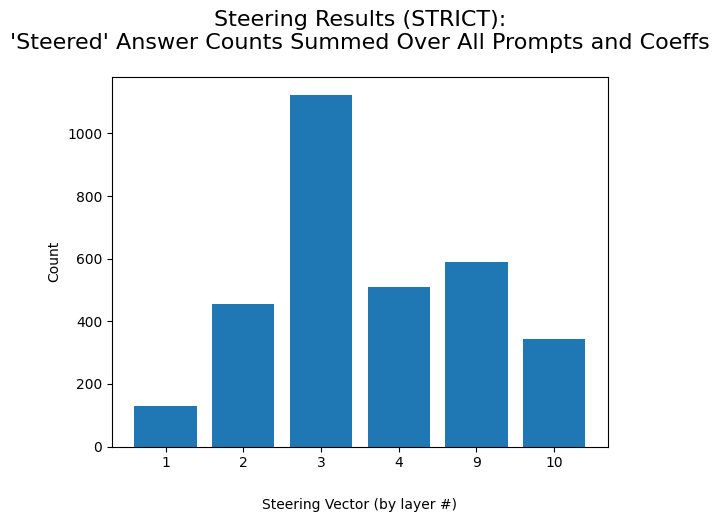

In [30]:
# Strict steering results summed over landmarks.
steering_counts_summed_over_landmarks_strict = steering_counts_all_strict.sum(
    dim=2
)  # shape (steering vectors, coeffs)
steering_counts_summed_over_landmarks_coeffs_strict = (
    steering_counts_summed_over_landmarks_strict.sum(dim=1)
)

print(steering_counts_summed_over_landmarks_strict)
print(steering_counts_summed_over_landmarks_coeffs_strict)

layers = list(steering_vectors_positions_by_layer.keys())


def create_sum_plot(summed_counts, steering_coeffs, labels, suptitle):
    fig, ax = plt.subplots(1, 1)
    fig.suptitle(suptitle, fontsize=16)

    for i in range(len(labels)):
        ax.plot(steering_coeffs, summed_counts[i, :], label=labels[i])
        ax.set_xscale("log")
        ax.set_xlabel("Steering Coefficients")
        ax.set_xlim([1, 5000])
        ax.set_ylabel("Count")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.2, 0.5), ncol=1)

    plt.tight_layout(rect=[-0.2, 0, 0.8, 0.98])
    plt.show()


def create_bar_plot(vals, labels, title, xlabel, ylabel, rotation=0):
    fig, ax = plt.subplots(1, 1)
    x_pos = np.arange(len(labels))
    ax.bar(x_pos, vals, align="center")
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xticks(np.arange(len(labels)), labels, rotation=rotation)
    ax.set_xlabel(xlabel, labelpad=20)
    ax.set_ylabel(ylabel)

    plt.show()


create_sum_plot(
    summed_counts=steering_counts_summed_over_landmarks_strict,
    steering_coeffs=coeffs,
    labels=[
        f"Layer {layer}, Feature Idx {svp['idx']}"
        for layer, svp in steering_vectors_positions_by_layer.items()
    ],
    suptitle="Steering Results Per Layer (STRICT):\n'Steered' Answer Counts Summed Over All Prompts",
)

create_bar_plot(
    steering_counts_summed_over_landmarks_coeffs_strict,
    layers,
    "Steering Results (STRICT):\n'Steered' Answer Counts Summed Over All Prompts and Coeffs",
    "Steering Vector (by layer #)",
    "Count",
)

['The Eiffel Tower', 'The Taj Mahal', 'The Statue of Liberty', 'The Colosseum', 'The Great Pyramid of Giza', 'Stonehenge', 'Petra', 'Macchu Picchu', 'Burj Khalifa', 'The Kremlin']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  69,  78,   0,   0,   0],
        [  0,   0,   0, 104,   0, 144, 107,   0,   0,   0],
        [156,  33, 200, 182,   0, 220,  76,   0,   0,   0],
        [174,   0, 363, 241,   0, 252, 155,   0,  17, 106],
        [  0,  59, 138,  42,   0,   0,  68,  32,  86,   0],
        [  0,   0,  48,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  

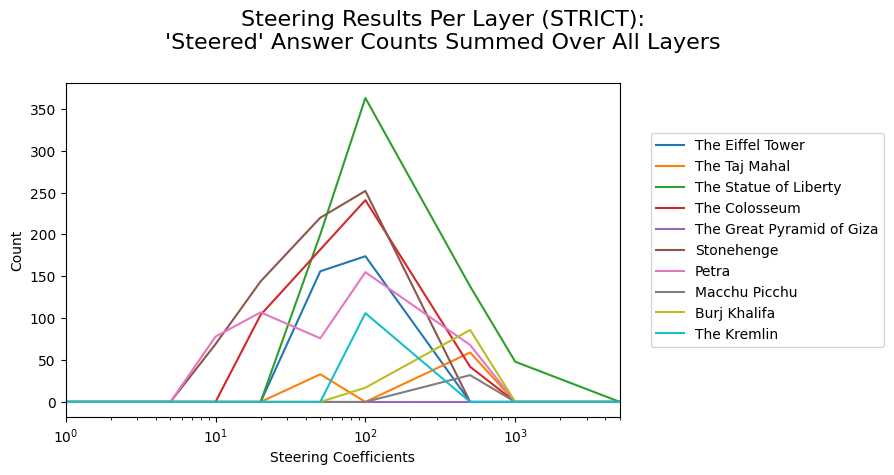

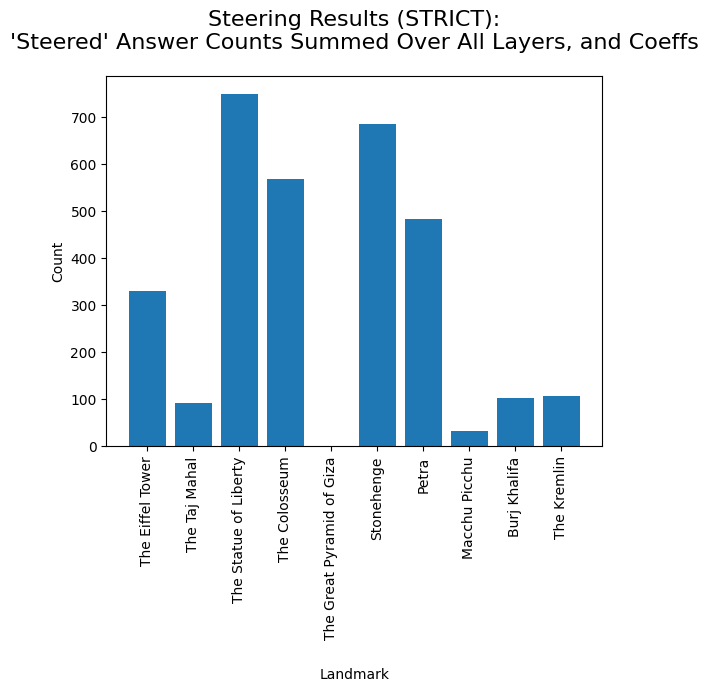

In [31]:
landmarks = [pair[0] for pair in landmark_country_pairs]
print(landmarks)

# Strict steering results by across all layers.
steering_counts_summed_over_layers_strict = steering_counts_all_strict.sum(
    dim=0
)  # shape (coeffs, landmarks)
print(steering_counts_summed_over_layers_strict)

# Strict steering results by across all layers and coeffs.
steering_counts_summed_over_layers_coeffs_strict = (
    steering_counts_summed_over_layers_strict.sum(dim=0)
)  # shape (landmarks)
print(steering_counts_summed_over_layers_coeffs_strict)

create_sum_plot(
    summed_counts=steering_counts_summed_over_layers_strict.T,
    steering_coeffs=coeffs,
    labels=landmarks,
    suptitle="Steering Results Per Layer (STRICT):\n'Steered' Answer Counts Summed Over All Layers",
)

create_bar_plot(
    steering_counts_summed_over_layers_coeffs_strict,
    landmarks,
    "Steering Results (STRICT):\n'Steered' Answer Counts Summed Over All Layers, and Coeffs",
    "Landmark",
    "Count",
    rotation=90,
)